# Optimizers, Hyperparameters, initializing parameters, weight decay/drop out ...

- 최적화에 사용되는 Optimizer에는 SDG 이외에도 여러가지가 있다. 경사하강법을 적절히 변형시킨 것들인데 학습목적에 맞는 것을 선택해야 한다.
- 학습 효율에 영향을 미치는 것들 중에서 학습 전에 조정해야 할 것들이 있다. Hyperparameter와 매개변수 초기화가 대표적이다.
- 학습 과정에서 오류를 발생시키는 것들 중 대표적인 것이 오버피팅 현상인데, 가중치 감소/드롭아웃 등의 정규화 기술이 있다.

## 1. Optimizers
대부분의 옵티마이저는 Gradient Descent 알고리즘의 다음 식을 변형한 것들이다. 
$$
\mathbf{W} \longleftarrow \mathbf{W} - \eta \frac{\partial L}{\partial \mathbf{W}}
$$
- $\eta$ : 학습률, $\mathbf{W}$ : 가중치 배열, $\frac{\partial L}{\partial \mathbf{W}}$ : 가중치에 대한 손실함수의 gradient
- 많은 손실이 날 수록(정답에서 많이 이탈할 수록, 경사가 심할 수록) 크게, 학습률에 비례하여, 손실이 줄어드는 방향으로, 가중치갱신이 일어난다.

### 1.1 SGD, Stochastic Gradient Descent
무작위로 미니배치를 선정하여 GD 하는 방식이다. 지금까지의 예제에서 사용했던 학습방법이다.
- 기울기에 따라 변동이 심하므로 학습 효율도 변동이 심하다.
- 비등방성anisotropy 함수의 경우 (에를 들어, $f(x,y) = \frac{1}{20} x^2 + y^2$)  탐색 방향에 따라 최적화 경로가 비효율적이 된다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
plt.style.use("seaborn")


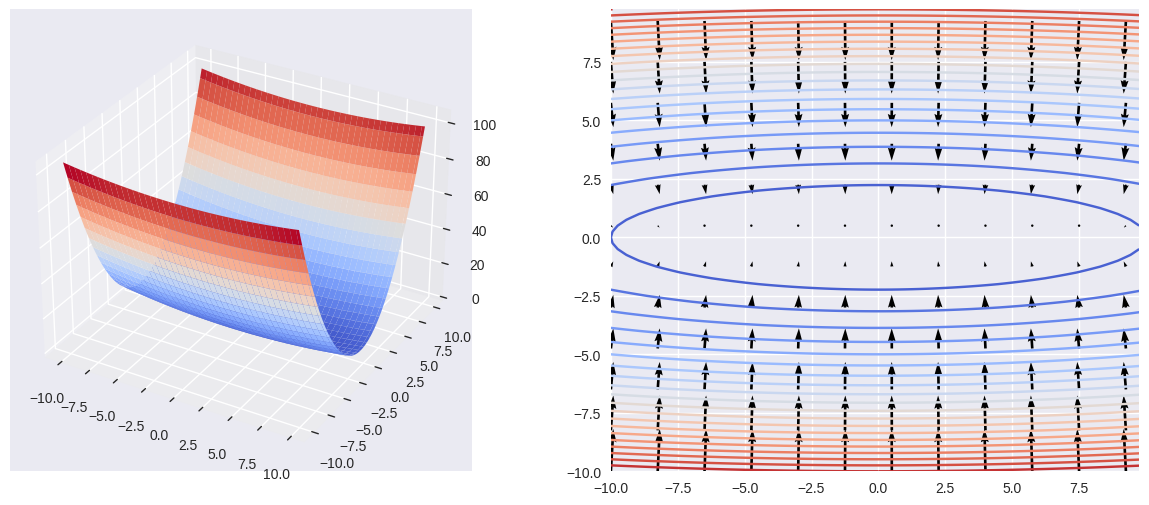

In [2]:
%matplotlib inline
f = lambda x, y: 1/20 * x**2 + y**2
f_ = lambda X: 1/20 * X[0]**2 + X[1]**2

x = np.arange(-10, 10, 0.25)
y = x.copy()
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

cmap = plt.get_cmap('coolwarm')
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(121, projection="3d")
ax1.plot_surface(X, Y, Z, cmap=cmap)
ax2 = fig.add_subplot(122)
ax2.contour(X,Y, Z, 20, cmap=cmap)

from common.functions import num_gradient, num_gradient_without_batch
step = 7
X, Y = X[::step, ::step], Y[::step, ::step] 
pts = np.vstack((X.flatten(), Y.flatten())).T
dx, dy = num_gradient(f_, pts).T
ax2.quiver(X, Y, -dx, -dy, angles='xy', scale=250)
plt.show()

### 1.2 Momentum
위에서 보듯 가로축방향으로의 학습이 매우 비효율적임을 알 수 있다. 그래서 기울기의 격차에 역비례하도록 학습률을 조정하게 되는데 아래의 알고리즘을 가지는 Momentum이 그렇게 설계되었다.  
$$\begin{align*}
v &\longleftarrow -\Big(\eta\frac{\partial L}{\partial \mathbf{W}} - \alpha v \Big) =\alpha v - \eta\frac{\partial L}{\partial \mathbf{W}} \\
\mathbf{W} &\longleftarrow \mathbf{W} + v 
\end{align*}$$
- $k$ 단계까지 거슬러 올라가 보면 다음과 같이 전개할 수 있다.
$$\begin{align*}
\mathbf{W}_{n+1} &= \mathbf{W}_n + v_n = \mathbf{W}_n + \Big(\alpha v_{n-1} - \eta\frac{\partial L}{\partial \mathbf{W}_{n-1}} \Big) \\
&= \mathbf{W}_n + \Big(\alpha \Big(\alpha v_{n-2} - \eta\frac{\partial L}{\partial \mathbf{W}_{n-2}}\Big) - \eta\frac{\partial L}{\partial \mathbf{W}_{n-1}} \Big) \\
& \vdots \\
&= \mathbf{W}_n + \alpha^k v_{n-k} - \eta\sum_{i=1}^k\frac{\partial L}{\partial \mathbf{W}_{n-k}} 
\end{align*}$$
- SGD는 현재 그래디언트값만이 갱신에 영향을 주는 반면, 모멘텀은 과거의 누적 갱신값이 현재 파라미터 갱신에 영향을 주는 구조임을 알 수 있다. 
- 그래서 모멘텀이란 이름이 붙여졌는데, 관성Inertia(누적된 과거의 갱신값)을 고려한 결과 관성력에 의해 로컬 최적점을 지나쳐 학습이 이루어지도록 하여 SGD의 문제였던 로컬 극값에서 학습중단이 일어나는 확률을 줄이고 더 나은 최적점을 학습을 할 수 있는 가능성을 높인다.
- $\alpha$ 가 클 수록 학습 갱신에 저항(누적된 과거의 영향력)을 많이 받는다. 즉, 학습이 작은 스텝으로 이루어진다. 
- 물리학에서의 모멘텀처럼 $\alpha$ 를 질량 $v$ 를 속도로 하여 해석하면 $\alpha v$는 momentum 에 대응한다.
- 물론 $\alpha v$ 를 속도에 비례하는 저항력(damping force) 또는 저항모멘텀으로도 해석한다. 그래서 $\alpha < 1$ 이 되도록 설정한다.
- 요지는 질량이 클 수록 가속 $\frac{\partial L}{\partial \mathbf{W}}$ 에 따른 속도변화가 작듯이 학습 진행도 그렇게 되도록 설계되었다.
- 학습 갱신량 ($\eta\frac{\partial L}{\partial \mathbf{W}} - \alpha v$) 이 현재속도($v$) 에 역비례($-\alpha$) 하고 최적점 근처에서의 속도가 가장 크므로 최적점에 가까울 수록 갱신량이 줄어든다.

In [3]:
class Momentum:
    def __init__(self, eta=0.01, alpha=0.9) -> None:
        self.eta = eta      # learning rate
        self.v = None          # velocity
        self.alpha = alpha  # mass
    def update(self, params, grads):
        if self.v is None:  # v == 0 at starting point
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        for key in params.keys():
            self.v[key] = self.alpha*self.v[key] - self.eta*grads[key]
            params[key] += self.v[key]

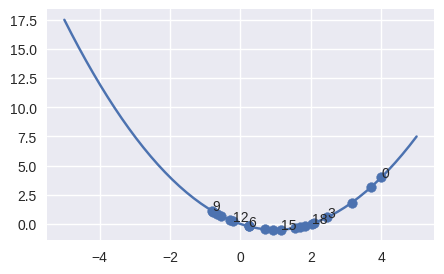

In [4]:
x = np.linspace(-5, 5)
f = lambda x: 0.5*x**2  - x
df = lambda x: x - 1
init = 4.0
params = {}
params['x'] = np.array([4.]) 
grads = {}
grads['x']  = 0
x_hist = []

mom = Momentum(eta=0.1, alpha=0.9)
for i in range(20):
    x_hist.append(*params['x'].copy())
    grads['x'] = df(params['x'])
    mom.update(params, grads)
y = f(np.array(x_hist))

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(x, f(x))
ax.scatter(x_hist, y)
for i, v in enumerate(x_hist):
    if i % 3 == 0:
        ax.annotate(i, (x_hist[i], y[i]))
plt.show()

### 1.3 Nesterov Accelerated Gradient, NAG
Nesterov Momentum은 현재 속도($v$) 대신에 현재 기울기로 계산된 다음 다음 속도를 저항속도로 사용하는 모멘텀이다. 즉,
$$
v \longleftarrow \alpha v - \eta\frac{\partial L}{\partial \mathbf{W}} \\
v \longleftarrow \alpha v - \eta\frac{\partial L}{\partial \mathbf{W}} \\
v \longleftarrow \alpha v - \eta\frac{\partial L}{\partial \mathbf{W}} \\
\mathbf{W} \longleftarrow \mathbf{W} +  v
$$
한 단계로 풀이하면,
$$
\mathbf{W} \longleftarrow \mathbf{W} + \alpha \Big(\alpha (\alpha v -\eta \frac{\partial L}{\partial \mathbf{W}}) - \eta \frac{\partial L}{\partial \mathbf{W}}\Big) -\eta \frac{\partial L}{\partial \mathbf{W}}
$$

- Damping oscillation 운동을 하는 모멘텀 옵티마이저는 관성으로 인해 최적점을 지나쳐 가게 되어 있다. Nestrov 모멘텀의 경우 이 문제를 조금 줄일 수 있다.
- 아이디어는 다음과 같다. 파라미터 스페이스에서 모멘텀 옵티마이저보다 $-\eta\frac{\partial L}{\partial \mathbf{W}}$ 방향에 더 가깝게 파라미터를 옮기는 것이다. 최적점은 그것이 가리키는 방향에 존재할 것이기 때문이다. 
$$\begin{align*}
v_n &\longleftarrow \alpha v_{n-1} - \eta\frac{\partial L}{\partial \mathbf{W}} \Big|_{\mathbf{W} = \mathbf{W}_n + \alpha v_{n-1}} \\
\mathbf{W}_{n+1} &\longleftarrow \mathbf{W}_n + v_n
\end{align*}$$
- 이렇게 구성하면, $\mathbf{W}$ 점, $\alpha v$ 점, 기울기벡터 $ -\eta\frac{\partial L}{\partial \mathbf{W}}$ 의 연장선상에 있을 최적점의 삼각형을 떠올리면 알 수 있듯, Momentum에서의 평행사변형 꼴의 대각선  보다 더 가까워지긴 하지만, $\mathbf{W}$ 를 $\mathbf{W}_n + \alpha v_{n-1}$ 으로 변경하여 구해야 하므로 불필요한 임시 가중치를 중복계산하게 되는 번거로움이 생긴다. 그래서,
- 가중치는 변경하지 말고 $v$를 누적해서 (2번 더) 구함으로서 벡터를 기울기방향으로 더 기울어지도록 하는 방법을 사용한다. 즉, 벡터합의 평행사변형 꼴을 기울기 벡터 $-\eta\frac{\partial L}{\partial \mathbf{W}}$ 방향으로 더 납작하게 하는 것이다. 처음의 식처럼 말이다.![](NAG.png)

In [5]:
class Nesterov:

    """Nesterov's Accelerated Gradient (http://arxiv.org/abs/1212.0901)"""
    # NAG는 모멘텀에서 한 단계 발전한 방법이다. 
    
    def __init__(self, eta=0.01, alpha=0.9):
        self.eta = eta
        self.alpha = alpha
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] *= self.alpha
            self.v[key] -= self.eta * grads[key]
            params[key] += self.alpha * self.alpha * self.v[key]
            params[key] -= (1 + self.alpha) * self.eta * grads[key]

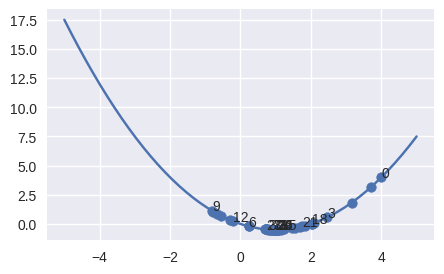

In [6]:
mom = Nesterov(eta=0.1, alpha=0.9)
for i in range(20):
    x_hist.append(*params['x'].copy())
    grads['x'] = df(params['x'])
    mom.update(params, grads)
y = f(np.array(x_hist))

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(x, f(x))
ax.scatter(x_hist, y)
for i, v in enumerate(x_hist):
    if i % 3 == 0:
        ax.annotate(i, (x_hist[i], y[i]))
plt.show()

In [7]:
w1 = np.random.randint(-9, 10, (3, 4)).astype(np.float32)
w1 / (np.sqrt(w1 * w1) + 1e-7)

array([[ 1.       , -1.       , -1.       , -1.       ],
       [-1.       ,  0.9999999, -1.       , -1.       ],
       [ 0.       ,  1.       ,  1.       , -1.       ]], dtype=float32)

In [8]:
class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

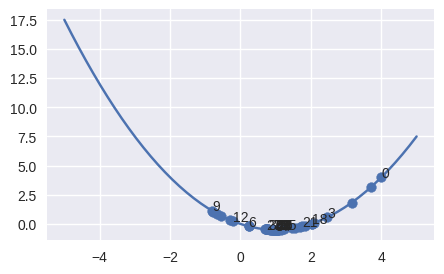

In [9]:
mom = AdaGrad(0.1)
for i in range(20):
    x_hist.append(*params['x'].copy())
    grads['x'] = df(params['x'])
    mom.update(params, grads)
y = f(np.array(x_hist))

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(x, f(x))
ax.scatter(x_hist, y)
for i, v in enumerate(x_hist):
    if i % 3 == 0:
        ax.annotate(i, (x_hist[i], y[i]))
plt.show()